In [1]:
import keras
from keras import ops

2025-01-28 15:25:02.674908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-28 15:25:02.768462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-28 15:25:02.794801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 15:25:02.990465: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Custom layer: residual block
<center><img src="residual_block.png" alt="Residual block" style="width: 150px;"/></center>

In [2]:
from keras.layers import Layer, BatchNormalization, Dense, Activation

class ResidualBlock(Layer):

    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.bn_1 = BatchNormalization()
        self.bn_2 = BatchNormalization()
        self.relu = Activation("relu")
        self.dense_1 = Dense(self.units)
        self.dense_2 = Dense(input_shape[-1])

    def call(self, inputs):
        x = self.bn_1(inputs)
        x = self.relu(x)
        x = self.dense_1(x)
        x = self.bn_2(x)
        x = self.relu(x)
        x = self.dense_2(x)
        return x + inputs

In [4]:
from keras.models import Sequential
from keras.layers import Input, Flatten

model = Sequential([
    Input(shape=(28, 28)),
    Flatten(),
    ResidualBlock(8, name='resnetblock1'),
    ResidualBlock(8, name='resnetblock2'),
    Activation('relu'),
    Dense(5, activation='softmax')
])

In [5]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnetblock1 (ResidualBlock)    │ (None, 784)            │        16,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnetblock2 (ResidualBlock)    │ (None, 784)            │        16,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         3,925 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,933 (144.27 KB)

 Trainable params: 33,765 (131.89 KB)

 Non-trainable params: 3,168 (12.38 KB)

#### Train on MNIST

In [6]:
from keras.datasets import mnist

(x_train, y_train), (x_val, y_val) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [8]:
import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_ds.element_spec

(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None))

In [9]:
def rescale(image, label):
    image = tf.cast(image, tf.float32) / 255.
    return image, label

train_ds = train_ds.map(rescale)
val_ds = val_ds.map(rescale)

train_ds.element_spec

(TensorSpec(shape=(28, 28), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None))

In [10]:
def filter_images(image, label):
    return tf.math.less_equal(label, 4)

train_ds = train_ds.filter(filter_images)
val_ds = val_ds.filter(filter_images)

train_ds.element_spec

(TensorSpec(shape=(28, 28), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None))

In [11]:
for i, l in train_ds.take(50):
    print(l)

tf.Tensor(0, shape=(), dtype=uint8)
tf.Tensor(4, shape=(), dtype=uint8)
tf.Tensor(1, shape=(), dtype=uint8)
tf.Tensor(2, shape=(), dtype=uint8)
tf.Tensor(1, shape=(), dtype=uint8)
tf.Tensor(3, shape=(), dtype=uint8)
tf.Tensor(1, shape=(), dtype=uint8)
tf.Tensor(4, shape=(), dtype=uint8)
tf.Tensor(3, shape=(), dtype=uint8)
tf.Tensor(3, shape=(), dtype=uint8)
tf.Tensor(1, shape=(), dtype=uint8)
tf.Tensor(2, shape=(), dtype=uint8)
tf.Tensor(4, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)
tf.Tensor(1, shape=(), dtype=uint8)
tf.Tensor(1, shape=(), dtype=uint8)
tf.Tensor(2, shape=(), dtype=uint8)
tf.Tensor(4, shape=(), dtype=uint8)
tf.Tensor(3, shape=(), dtype=uint8)
tf.Tensor(2, shape=(), dtype=uint8)
tf.Tensor(3, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)
tf.Tensor(1, shape=(), dtype=uint8)
tf.Tensor(3, shape=(), dtype=uint8)
tf.Tensor(3, shape=(), dtype=uint8)
tf.Tensor(3, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype

2025-01-28 15:53:02.134089: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Custom callback

In [12]:
import matplotlib.pyplot as plt
from keras.callbacks import Callback
import numpy as np


class PlotPredictions(Callback):
    
    def __init__(self, test_input):
        super().__init__()
        self.test_input = test_input
        
    def on_epoch_end(self, epoch, logs=None):
        plt.close()
        preds = np.squeeze(self.model(ops.expand_dims(self.test_input, axis=0)).numpy())
        plt.bar(np.arange(len(preds)), preds)
        plt.xticks(np.arange(len(preds)))
        plt.title(f"Categorical distribution, epoch {epoch}")
        plt.show()

In [13]:
for image, label in val_ds.take(1):
    test_input = image
    print(label)

tf.Tensor(2, shape=(), dtype=uint8)


2025-01-28 15:55:36.627989: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


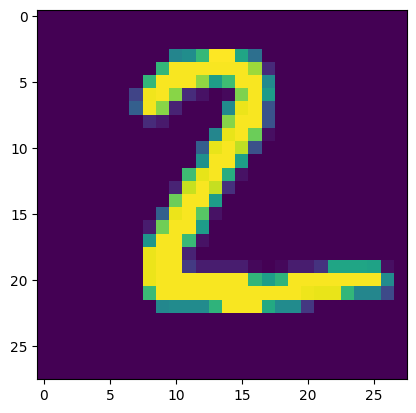

In [14]:
plt.imshow(np.squeeze(test_input.numpy()))

In [15]:
plot_predictions = PlotPredictions(test_input)

In [16]:
train_ds = train_ds.shuffle(1000).batch(512).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(512).prefetch(tf.data.AUTOTUNE)

In [17]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), 
              loss='sparse_categorical_crossentropy')

Epoch 1/10


I0000 00:00:1738079930.647251    1083 service.cc:146] XLA service 0x71081800d9e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738079930.647843    1083 service.cc:154]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2025-01-28 15:58:50.844674: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-28 15:58:51.161651: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
2025-01-28 15:59:05.016538: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_200', 160 bytes spill stores, 160 bytes spill loads

2025-01-28 15:59:10.910417: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fu

      5/Unknown 26s 48ms/step - loss: 1.6259

I0000 00:00:1738079955.233734    1083 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     58/Unknown 30s 70ms/step - loss: 1.4441

2025-01-28 15:59:27.710454: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_200', 8 bytes spill stores, 8 bytes spill loads

2025-01-28 15:59:34.810638: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1074', 4 bytes spill stores, 4 bytes spill loads

2025-01-28 15:59:34.910544: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_790', 4 bytes spill stores, 4 bytes spill loads

2025-01-28 15:59:36.110547: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1077', 8 bytes spill stores, 8 bytes spill loads

2025-01-28 15:59:38.217136: I external/local_xla/xla/stream_executor/c

     60/Unknown 56s 510ms/step - loss: 1.4386

2025-01-28 15:59:45.345633: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-28 15:59:45.345691: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 15:59:45.345714: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1750357586342135218
2025-01-28 15:59:51.926577: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_63', 8 bytes spill stores, 8 bytes spill loads

2025-01-28 15:59:53.119518: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_63', 184 bytes spill stores, 184 bytes spill loads

2025-01-28 15:59:53.130360:

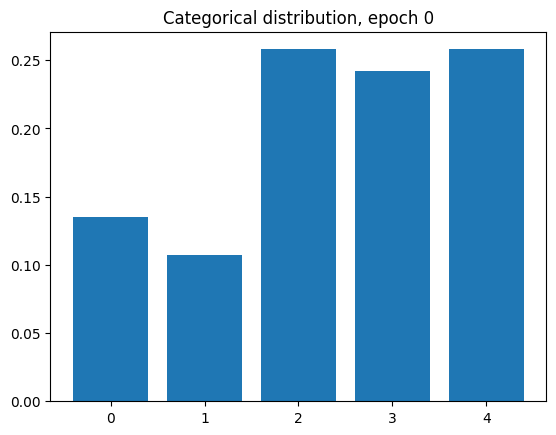

60/60 ━━━━━━━━━━━━━━━━━━━━ 65s 658ms/step - loss: 1.4359 - val_loss: 1.1299
Epoch 2/10
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.8766

2025-01-28 15:59:58.419048: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-28 15:59:58.419102: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 15:59:58.419123: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1750357586342135218
2025-01-28 15:59:59.234905: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 15:59:59.234974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1750357586342135218


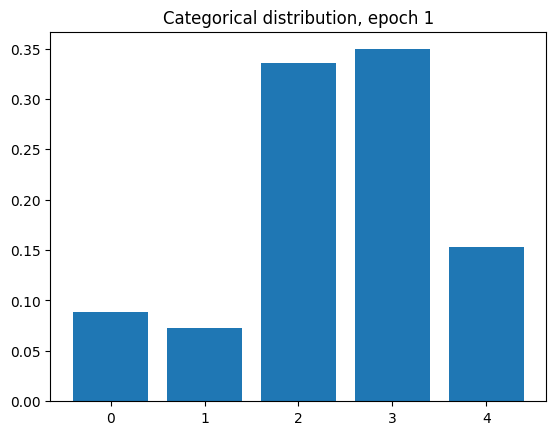

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.8717 - val_loss: 0.7335
Epoch 3/10
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.5271

2025-01-28 16:00:04.750754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 16:00:04.750820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1750357586342135218


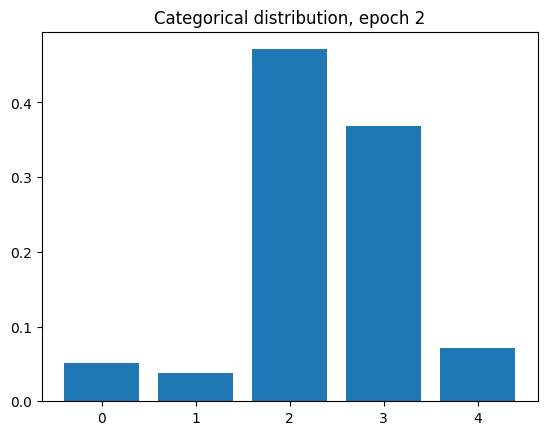

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.5241 - val_loss: 0.4550
Epoch 4/10
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.3310

2025-01-28 16:00:09.147948: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-28 16:00:09.148001: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 16:00:09.148021: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1750357586342135218
2025-01-28 16:00:09.854223: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 16:00:09.854290: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1750357586342135218


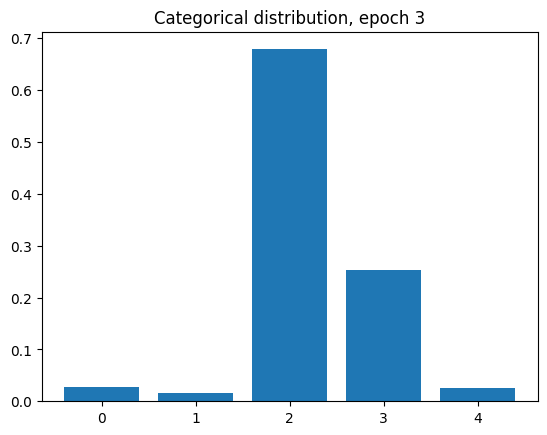

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.3289 - val_loss: 0.2869
Epoch 5/10
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.2325

2025-01-28 16:00:14.343327: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 16:00:14.343394: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1750357586342135218
2025-01-28 16:00:15.059294: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 16:00:15.059354: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1750357586342135218


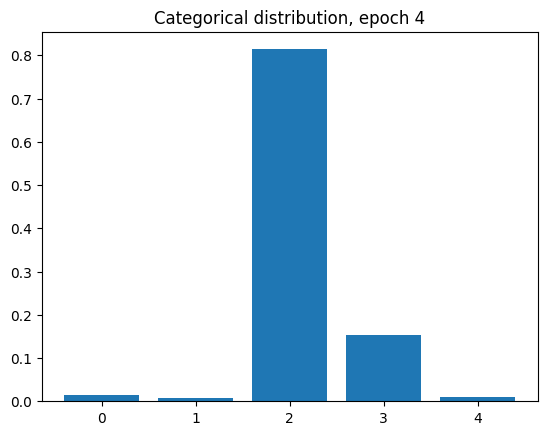

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.2313 - val_loss: 0.1961
Epoch 6/10
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1825

2025-01-28 16:00:19.416436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 16:00:20.118877: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 16:00:20.118946: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1750357586342135218


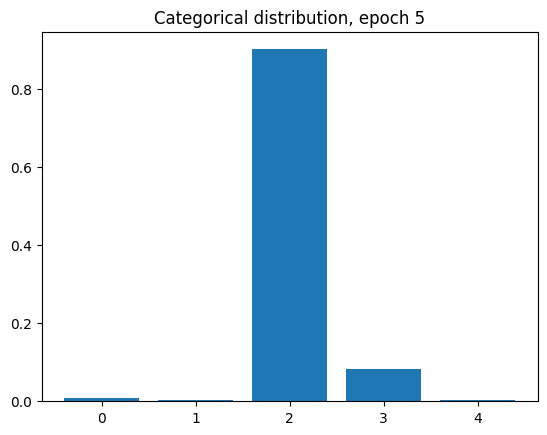

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.1818 - val_loss: 0.1472
Epoch 7/10
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1546

2025-01-28 16:00:24.619362: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 16:00:24.619423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1750357586342135218
2025-01-28 16:00:25.317976: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 16:00:25.318043: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1750357586342135218


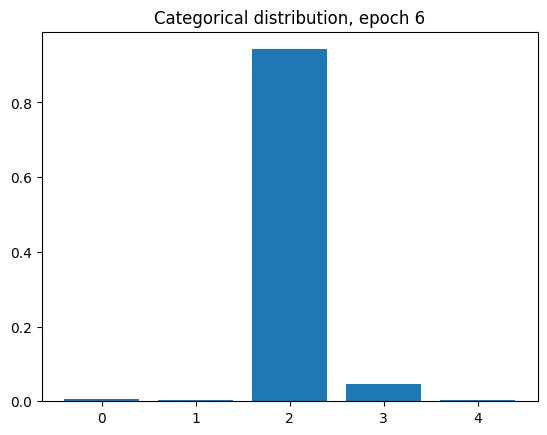

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.1540 - val_loss: 0.1208
Epoch 8/10
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1373

2025-01-28 16:00:29.716113: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-01-28 16:00:29.716176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 16:00:30.439470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 16:00:30.439537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1750357586342135218


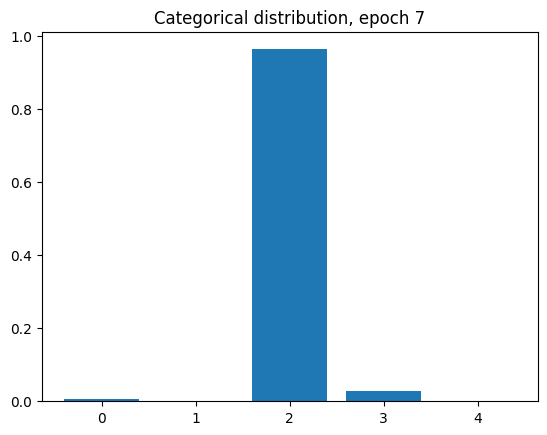

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.1369 - val_loss: 0.1040
Epoch 9/10
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1227

2025-01-28 16:00:35.720961: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 16:00:35.721035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1750357586342135218


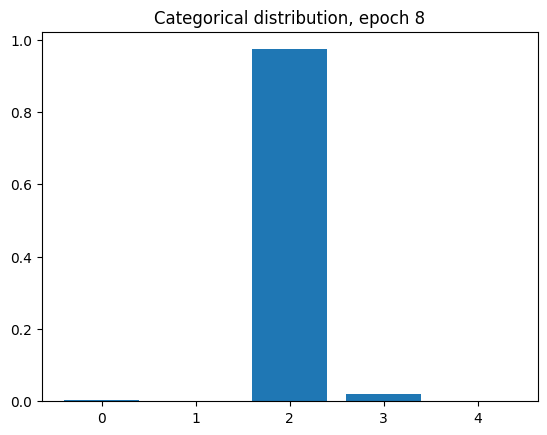

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.1224 - val_loss: 0.0931
Epoch 10/10
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1132

2025-01-28 16:00:40.920548: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5140229559365579753
2025-01-28 16:00:40.920617: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1750357586342135218


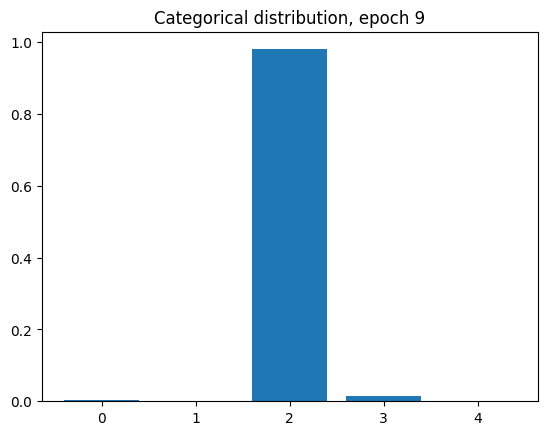

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.1129 - val_loss: 0.0855


In [18]:
model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[plot_predictions])